#**Imports**

The project is implemented using [PyTorch](https://pytorch.org/) framework.

In [1]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, HTML
import time
import PIL
import glob
from base64 import b64encode
import datetime
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision import models
from torchvision import transforms as T

from fastai.callbacks import hook_outputs
from fastai.torch_core import requires_grad, children

In [2]:
torch.backends.cudnn.deterministic = True 
# check if training using GPU is possible
torch.cuda.is_available()

True

#**Defining paths to save and load data**

In [3]:
# mounting Google Drive with your credentials 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [42]:
# folder, created in advance in the Google Drive and containing kaggle.json
#project_folder = '/content/gdrive/MyDrive/Kaggle/NaturalPainters' # for parent email
project_folder = '/content/gdrive/MyDrive/NaturalPainters' # for alternative emails
os.environ['KAGGLE_CONFIG_DIR'] = project_folder

In [43]:
# dive into folder
#%cd /content/gdrive/MyDrive/Kaggle/NaturalPainters
%cd /content/gdrive/MyDrive/NaturalPainters

/content/gdrive/.shortcut-targets-by-id/1m2LH2VheZ1KLU1PiFqOKItm5-sBWZ1C4/NaturalPainters


This is the $4$th notebook in the project, consisting of the $4$ notebooks. 

In the previous module the **GAN Generator** model has been trained to be loaded now **as pre-trained** and used with the **freezed** weights.

In [33]:
# path to load the GAN generator weights
generator_path = project_folder + "/models/gan/GAN_generator_2022-02-16 23:25:53.817520_5e.pth"
# path to load images amongst which you can choose what to draw
load_images_path = project_folder + '/images/source_images/*'
# path to save images that we eventually paint
save_images_path = project_folder + '/images/painted_images/'
# path to save painting loss
plots_path = project_folder + '/images/loss_plots/paint_'

In [7]:
# there are links to images that were taken from the reference github for the paper
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/vanc.jpg
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/louvre.png
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/eiffel.jpeg
# !wget -c https://github.com/reiinakano/neural-painters-pytorch/blob/master/images/castle.png

In [8]:
# for repeatability of the experiments
current_best = True
if current_best:
    SEED = 4
else:
    SEED = random.randint(1, 1000)
print(f'Series of experiments corresponding to a SEED = {SEED} be recreated.')

Series of experiments corresponding to a SEED = 4 be recreated.


In [71]:
# utility for automatic generation of unique paths for saving
def generate_path(epochs, img_to_paint_name = '', inter_folder = '', mode = ''):
    # to avoid overwriting while saving models
    dt = datetime.datetime.now().replace(second = 0, microsecond = 0)
    save_path = str(dt).strip() + f'_{epochs}e_{SEED}seed'

    if mode == 'loss':
        path = plots_path + save_path + '.png'
    else:
        path = save_images_path + img_to_paint_name + inter_folder + img_to_paint_name + '_' + save_path

    return path

# **GAN Generator**

The GAN Generator is needed **to generate brushstrokes** by which agent will perform painting.

## **Generator Model**

Defining the model layers.

In [10]:
class Generator(nn.Module):

    def __init__(self, 
                 in_features: int,
                 img_height: int,
                 img_width: int,
                 num_features: int,
                 img_channels: int):
        super(Generator, self).__init__()
      
        # we want to obtain 64 x 64 images
        self.out_features = img_height * img_width

        # (12, 64 x 64) = (12, 4096), 12 - shape of each action
        self.lin = nn.Linear(in_features, self.out_features)
        # (4096, 512), 512 - downsampling hparam
        self.conv1 = nn.ConvTranspose2d(self.out_features, num_features, 
                                        kernel_size = (4, 4), stride = (1, 1), bias = False)
        self.norm1 = nn.BatchNorm2d(num_features) # 512
        # (512, 256)
        self.conv2 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm2 = nn.BatchNorm2d(num_features) # 256
        # (256, 128)
        self.conv3 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm3 = nn.BatchNorm2d(num_features) # 128
        # (128, 64)
        self.conv4 = nn.ConvTranspose2d(num_features, num_features//2, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)
        num_features //= 2
        self.norm4 = nn.BatchNorm2d(num_features) # 64
        # (64, 64)
        self.conv5 = nn.ConvTranspose2d(num_features, num_features, 
                                        kernel_size = (3, 3), stride = (1, 1), padding = (1, 1), bias = False)
        self.norm5 = nn.BatchNorm2d(num_features) # 64
        # (64, 3)
        self.conv6 = nn.ConvTranspose2d(num_features, img_channels, 
                                        kernel_size = (4, 4), stride = (2, 2), padding = (1, 1), bias = False)



    def forward(self, x):
        # fully-convolutional layer
        x = self.lin(x)
        # CNN: all non-residual convolutional layers are followed by spatial batch normalization and ReLU nonlinearities 
        # with the exception of the output layer: uses a scaled tanh to ensure that the output image has pixels in range [0, 255]
        x = F.relu(self.conv1(x.view(x.size(0), x.size(1), 1, 1)), inplace = True)
        x = self.norm1(x)
        x = F.relu(self.conv2(x), inplace = True)
        x = self.norm2(x)
        x = F.relu(self.conv3(x), inplace = True)
        x = self.norm3(x)
        x = F.relu(self.conv4(x), inplace = True)
        x = self.norm4(x)
        x = F.relu(self.conv5(x), inplace = True)
        x = self.norm5(x)

        return torch.tanh(self.conv6(x))

## **Feature Extractor**

To train the Painter, we need to compute the **Pereptual Loss** between generated canvas and source image: https://arxiv.org/abs/1603.08155.

In turn, for that we need to load **pre-trained Feature Extractor**. Choice of the Extractor $-$ one of the hyperparameters of the pipeline.

19-layers VGG (**VGG-19**) with batch normalization pre-trained on ImageNet: https://arxiv.org/pdf/1409.1556.pdf has been chosen.

In [11]:
class FeatureExtractor(nn.Module):

    def __init__(self, 
                 layers_weights,
                 lambda_s,
                 device):
      super(FeatureExtractor, self).__init__()
      
      self.layers_weights = layers_weights # hparam
      self.lambda_s = lambda_s # weighting factor for style reconstruction loss
      self.device = device
      self.feature_extractor, self.layers_indices = self.extractor() # load Feature Extractor 

      # return Hooks that store activations of all modules in self.stored
      # function that creates a Hook for all passed modules that simply stores the output of the layers 
      # we take only modules of interest
      self.outputs = hook_outputs([self.feature_extractor[i] for i in self.layers_indices], detach = False)

    def extractor(self):

        print('Download VGG19 (batch normalized) as pre-trained.\n')
        # evaluation regime, no need to re-train
        extractor = models.vgg19_bn(pretrained = True, progress = True).features.eval()

        if self.device == 'cuda':
            extractor = extractor.cuda()

        # don't want to compute gradients
        requires_grad(extractor, False)

        # features and list of indices of layers with activations (only last ones for high-level features)
        return extractor, [i - 1 for i, layer in enumerate(children(extractor)) if isinstance(layer, nn.MaxPool2d)][2:]

    # Gram matrix G is used to compute Style Reconstruction Loss
    # C x H x W - image size
    # features - C-dimensional features for each cell on H x W image grid
    # G is proportional to the uncentered covariance of the C-dimensional features, treating each grif location independently
    # idea - captures information about which features tend to activate together
    def gram_matrix(self, input):

        (batch_size, c, h, w) = input.size()
        # Gram matrix can be computed efficiently by reshaping into (c, hw)
        features = input.view(batch_size, c, h * w)
        G = features @ features.transpose(1, 2)
        # C x H x W is a normalizing factor
        return G.div(c * h * w)

    # where the perceptual loss is computed
    def forward(self, gen_stroke, true_stroke):

        # put extracted features of the generated image into storage
        self.feature_extractor(gen_stroke)
        # create list of features of each layer taking them from storage
        gen_stroke_features = [out for out in self.outputs.stored]
        
        # repeat procedure for the true image
        self.feature_extractor(true_stroke)
        true_stroke_features = [out.clone() for out in self.outputs.stored]

        # weighted sum of Feature Reconstruction Loss, Style Reconstruction Loss and 
        self.loss = []
        
        # Feature Reconstruction Loss
        # penalizes deviations in content and overall spacial structure
        # computed as MAE between feature maps with weight of objective lambda_c
        # lambda_c is a list of weights - different for each level of feature maps, it is stored in self.layers_weights
        feature_loss = [F.l1_loss(gen_layer, true_layer) * weight 
                        for gen_layer, true_layer, weight in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]
        
        # Style Reconstruction Loss
        # penalizes differences in style: colors, textures, exact shapes, common patterns, etc
        # computed as MAE between gram matriceswith weight of objective lambda_s
        # lambda_s is a list of weights - different for each level of freature maps
        # but in our case lambda_s is a constant factor intended to tweak importance between Feature and Style Reconstruction Losses
        # style_loss_weight[i] = feature_loss_weight[i]^2 * lambda_s
        style_loss = [F.l1_loss(self.gram_matrix(gen_layer), self.gram_matrix(true_layer)) * weight**2 * self.lambda_s 
                      for gen_layer, true_layer, weight  in zip(gen_stroke_features, true_stroke_features, self.layers_weights)]

        # Pixel Loss
        # encourages the pixels of the generated image to exactly match the pixels of the target image
        # computed as MAE between two images
        pixel_loss = [F.l1_loss(gen_stroke, true_stroke)]

        self.loss += feature_loss + style_loss + pixel_loss
                
        return sum(self.loss)

    def __del__(self):
        self.outputs.remove()

# **Training Playground**

Differently from the previous modules, we don't start training on the Playground. 

Instead, at the current step hyperparameters are set up and GAN Generator is instantiated and prepared to inference.

In [12]:
# set either repeated or random experiment
torch.manual_seed(SEED)

# set hyperparameters: right pannel provides the playground
class Hparams():
    in_strokes = 50 #@param {type:"slider", min:8, max:1024, step:8}
    in_features = 12 #constant
    num_features = 512 #@param {type:"slider", min:8, max:1024, step:8}
    img_height = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_width = 64 #@param {type:"slider", min:8, max:1024, step:8}
    img_channels = 3 #@param {type:"slider", min:1, max:3, step:2}
    layers_weights = [5, 15, 2] #@param
    lambda_s = 5000 #@param {type: "slider", min:1, max:5000}
    lr = 0.01 #@param {type:"number"}
    epochs = 3000 #@param {type:"slider", min:1, max:4000, step:1}
    print_interval = 100 #@param {type:"slider", min:1, max:100, step:10}
    secs = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.05}
hparams = Hparams()

# define device for training
gpu = torch.cuda.is_available()
if gpu:
    print("Training will be performed using GPU.\n")
    device = 'cuda'
else:
    print("Training will be performed using CPU.\n")
    device = 'cpu'

# create model instance of Generator
generator = Generator(hparams.in_features,
                      hparams.img_height,
                      hparams.img_width,
                      hparams.num_features,
                      hparams.img_channels)

# create model instance of Feature Extractor
feature_extractor = FeatureExtractor(hparams.layers_weights,
                                     hparams.lambda_s, 
                                     device)
# load the GAN Generator's learnt parameters
generator.load_state_dict(torch.load(generator_path, 
                                     map_location = torch.device(device)))

# freezing the weights
for param in generator.parameters():
    param.requires_grad = False

# evaluation regime, no need to re-train
generator.to(device).eval()                

Training will be performed using GPU.

Download VGG19 (batch normalized) as pre-trained.



Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Generator(
  (lin): Linear(in_features=12, out_features=4096, bias=True)
  (conv1): ConvTranspose2d(4096, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (norm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

# **Blending**

We want to paint an image with a certain number of strokes (hyperparameter of the painting agent) used, therefore **methodology to blend several strokes on canvas** is needed.

Blending idea, described in https://reiinakano.com/2019/01/27/world-painters.html has been implemented in the routine below.

In [13]:
def paint_image(gen_strokes, gpu, test_mode = False, save_path = '', stack_interval = 8):

        canvas_evolution = []

        # returns a tensor filled with the scalar value `1` (white), with the same size as gen_strokes[0]
        # so canvas is a white area of a size (3, 64, 64)
        canvas = torch.ones_like(gen_strokes[0], requires_grad = True, dtype = torch.float32)
        if test_mode:
            gen_strokes_h = torch.ones(([gen_strokes[0].shape[0], 
                                        gen_strokes[0].shape[1], 
                                        gen_strokes[0].shape[2] * stack_interval])).cpu()

        # iterating over num_strokes to paint
        for i, stroke in enumerate(gen_strokes):

            size = stroke.shape[1]

            # what we want to do is to calculate the “opacity” of an individual brush stroke pixel 
            # by computing how dark it is relative to the darkest pixel (full opacity) in the brush stroke

            # in the following lines we compute brush_color - the darkest value inside the channel
            # we iterate over 3 channels and image rows and compute for each row minimum (darkest) value in column - output is (3, 64)
            # then we iterate inside row and get the darkest color for each channel - output is 3 values
            # the values obtained can be out of interval [0, 1] (between black and white), therefore we force (clamp) them to this interval
            # we make reshape 3 -> (1, 3, 1, 1) - batch of one image with 3 channels of size (1, 1)
            # we expand the darkest value of channel for the full image size in this channel - output is (1, 3, 64, 64) 
            brush_color = stroke.min(1)[0].min(1)[0].clamp_(0, 1).view(-1, 3, 1, 1)
            brush_color = brush_color.expand(-1, 3, size, size)

            # get the "darkness" of each individual pixel in a stroke by averaging
            # in other words, each pixel is represented by 3 channels
            # we define darkness of a pixel as an average amongst its values in 3 channels - output is (64, 64)
            darkness_mask = torch.mean(stroke, 0)

            # make the value of a darker stroke higher
            # first we reshape mask from (64, 64) to (1, 1, 64, 64) to have the same niumber of dimensions as brush_stroke
            # originally the darker values are lower, by subtracting from 1, the darker values are higher
            # so, now, the closer to 1 - darker
            darkness_mask = 1 - torch.reshape(darkness_mask, (-1, 1, size, size))

            # scale this darkness mask from 0 to 1 by dividing each value in mask on the maximum possible in the mask
            darkness_mask = darkness_mask / torch.max(darkness_mask)

            # replace the original stroke with one that has all colored pixels set to the actual color used in two steps

            # step 1: boolean mask corresponding to the size of image (3, 64, 64) which if the value was 1 (white) contains True, otherwise False 
            stroke_whitespace = torch.eq(stroke, 1.)

            # step 2: if at the given coordinate in stroke there was white we will keep white,
            # if there was some another value - we take the darkest in this channel
            maxed_stroke = torch.where(stroke_whitespace, stroke, brush_color)

            if gpu:
                maxed_stroke = maxed_stroke.cuda()
                darkness_mask = darkness_mask.cuda()

            # linearly blend
            # that means that if the pixel of current stroke is dark, it has a large value and we keep mostly it + a little bit of canvas
            # if stroke pixel is light, then we take a little bit of it and mostly canvas value
            canvas = (darkness_mask) * maxed_stroke + (1 - darkness_mask) * canvas

            cur_canvas = to_pil_image(canvas.clone().cpu().squeeze())
            canvas_evolution.append(cur_canvas)

            if test_mode:
                print(f'Current stroke {i + 1}/{len(gen_strokes)} and canvas after adding it:\n')
                display(to_pil_image(torch.cat((stroke.clone().cpu(), canvas.clone().cpu().squeeze()), dim = 2)))
                if i == 0:
                    gen_strokes_w = canvas.clone().cpu().squeeze()
                elif i == stack_interval:
                    gen_strokes_h = gen_strokes_w.clone()
                    gen_strokes_w = canvas.clone().cpu().squeeze()
                elif i % stack_interval == 0:
                    gen_strokes_h = torch.cat((gen_strokes_h, gen_strokes_w), dim = 1)
                    gen_strokes_w = canvas.clone().cpu().squeeze()
                else:
                    gen_strokes_w = torch.cat((gen_strokes_w, canvas.clone().cpu().squeeze()), dim = 2)

        if save_path != '':
            print('\nBlending progress for the examples of the generated strokes:')
            gen_strokes_h = torch.cat((gen_strokes_h, gen_strokes_w), dim = 1)
            display(to_pil_image(gen_strokes_h))
            to_pil_image(gen_strokes_h).save(save_path, optimize = True, subsampling = 0, quality = 100)
            print(f"\nImage is saved to {save_path}.")

        return canvas, canvas_evolution


Let's try to blend $32$ strokes from dataset even before training the Netural Painter just to test if blending function perform its work well.

Current stroke 1/32 and canvas after adding it:



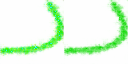

Current stroke 2/32 and canvas after adding it:



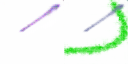

Current stroke 3/32 and canvas after adding it:



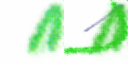

Current stroke 4/32 and canvas after adding it:



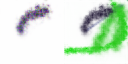

Current stroke 5/32 and canvas after adding it:



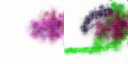

Current stroke 6/32 and canvas after adding it:



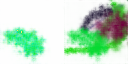

Current stroke 7/32 and canvas after adding it:



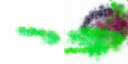

Current stroke 8/32 and canvas after adding it:



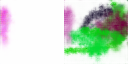

Current stroke 9/32 and canvas after adding it:



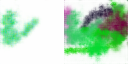

Current stroke 10/32 and canvas after adding it:



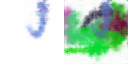

Current stroke 11/32 and canvas after adding it:



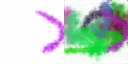

Current stroke 12/32 and canvas after adding it:



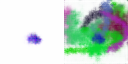

Current stroke 13/32 and canvas after adding it:



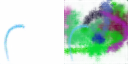

Current stroke 14/32 and canvas after adding it:



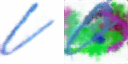

Current stroke 15/32 and canvas after adding it:



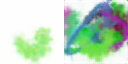

Current stroke 16/32 and canvas after adding it:



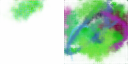

Current stroke 17/32 and canvas after adding it:



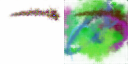

Current stroke 18/32 and canvas after adding it:



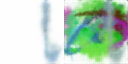

Current stroke 19/32 and canvas after adding it:



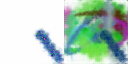

Current stroke 20/32 and canvas after adding it:



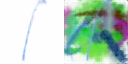

Current stroke 21/32 and canvas after adding it:



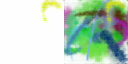

Current stroke 22/32 and canvas after adding it:



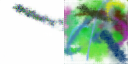

Current stroke 23/32 and canvas after adding it:



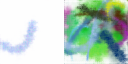

Current stroke 24/32 and canvas after adding it:



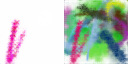

Current stroke 25/32 and canvas after adding it:



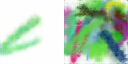

Current stroke 26/32 and canvas after adding it:



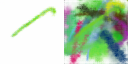

Current stroke 27/32 and canvas after adding it:



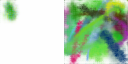

Current stroke 28/32 and canvas after adding it:



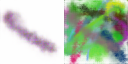

Current stroke 29/32 and canvas after adding it:



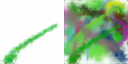

Current stroke 30/32 and canvas after adding it:



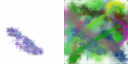

Current stroke 31/32 and canvas after adding it:



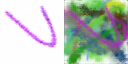

Current stroke 32/32 and canvas after adding it:



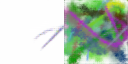


Blending progress for the examples of the generated strokes:


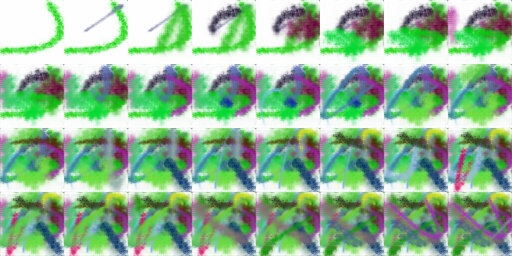


Image is saved to /content/gdrive/MyDrive/NaturalPainters/images/painted_images/blending.png.

Canvas is a tensor and has shape torch.Size([1, 3, 64, 64]).
Canvas evolution is a list and has a length 32.


In [14]:
# execute this cell if you would like to check blending before painting
def test_blending(npz, in_strokes, generator):

    data = np.load('strokes-dataset/' + npz)

    strokes = torch.stack([torch.from_numpy(stroke).permute(2, 0, 1) for stroke in data['strokes']])
    actions = torch.stack([torch.from_numpy(action).float() for action in data['actions']])

    dataset = TensorDataset(strokes, actions)

    dataloader = DataLoader(dataset, 
                            batch_size = in_strokes, 
                            shuffle = False)

    for (stroke, action) in dataloader:
        if next(generator.parameters()).is_cuda:
          action = action.cuda()
        gen_strokes = generator(action)
        break

    return paint_image(gen_strokes, next(generator.parameters()).is_cuda, 
                       test_mode = True, 
                       save_path = save_images_path + 'blending.png',
                       stack_interval = in_strokes // 4)
  

canvas, canvas_evolution = test_blending(npz = 'episodes_2.npz', in_strokes = 32, generator = generator)
print(f"\nCanvas is a tensor and has shape {canvas.shape}.")
print(f"Canvas evolution is a list and has a length {len(canvas_evolution)}.")

# **Loading image for painting**

We don't have dataset, but we can download any image of interest to paint.

In [15]:
def load_img(img_path, 
             thumb_size = None, 
             crop = 256, 
             out_size = None):
    
        # load ti PIL
        img = PIL.Image.open(img_path)
        # some image processing to prepare image for agent input while making sure that it hasn't been corrupted
        if thumb_size is not None:
            img.thumbnail((thumb_size, thumb_size), PIL.Image.ANTIALIAS)
            if (img.size[1] > crop) and (img.size[1] < (2 * crop)):
                img = T.CenterCrop(crop)(img)
        if out_size is not None:
            img = img.resize((out_size, out_size))

        return img

Images to reconstruct have been dowloaded from here: https://github.com/reiinakano/neural-painters-pytorch/tree/master/images.

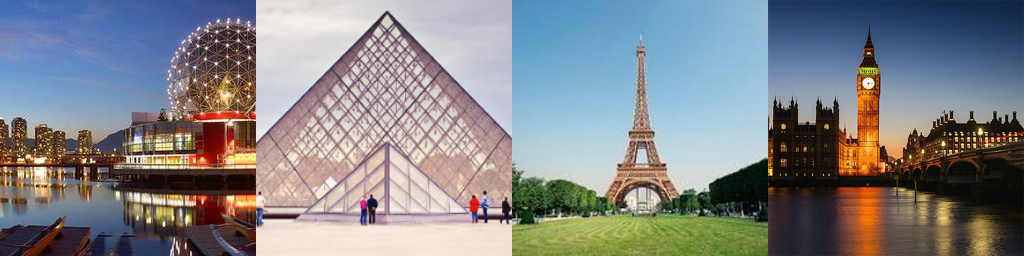

In [16]:
image_list = []
image_path_list = []
for i, img_path in enumerate(glob.glob(load_images_path)):
    img = load_img(img_path, thumb_size = 512, crop = 256, out_size = 256)
    image_list.append(img)
    image_path_list.append(img_path)

image_array = np.array(image_list[0])
for i in range(1, len(image_list)):
    image_array = np.hstack((image_array, np.array(image_list[i])))

source_images = PIL.Image.fromarray(image_array)
display(source_images)


Image to paint is an image of vanc:


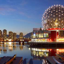


Image to paint is an image of louvre:


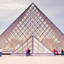


Image to paint is an image of eiffel:


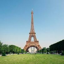


Image to paint is an image of castle:


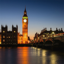


Each image tensor has size torch.Size([3, 64, 64])


In [17]:
# let's generate source content
def generate_source_to_paint(img_path):
    img_to_paint = load_img(img_path, thumb_size = 512, crop = 256, out_size = hparams.img_height)
    img_to_paint_name = img_path.split('/')[-1].split('.')[0]
    print(f"\nImage to paint is an image of {img_to_paint_name}:")
    display(img_to_paint)
    img_to_paint_tensor = to_tensor(img_to_paint).to(device)
    return img_to_paint_name, img_to_paint, img_to_paint_tensor

for img_path in image_path_list:
  img_to_paint_name, img_to_paint, img_to_paint_tensor = generate_source_to_paint(img_path)
print(f"\nEach image tensor has size {img_to_paint_tensor.shape}")

# **Painting**

## **Neural Painter Class**

In [18]:
class Trainer():

        def __init__(self,
                    generator: nn.Module,
                    feature_extractor: nn.Module,
                    optimizer: torch.optim,
                    img_to_paint_tensor: torch.Tensor,
                    epochs: int = 1000,
                    gpu: bool = False):
                super(Trainer, self).__init__()

                self.generator = generator # get Generator model to generate strokes for painting
                self.feature_extractor = feature_extractor # get feature extractor to compute perceptual loss
                self.optimizer = optimizer # get optimizer to perform training
                self.img_to_paint_tensor = img_to_paint_tensor # source image in a tensor form
                self.epochs = epochs
                self.gpu = gpu

        def train(self,
                actions,
                print_interval: int = 100,
                save_img_path: str = '',
                verbose: bool = True):

            self.train_canvas_collection = [] # to collect images of final canvases iterating over training steps

            train_loss = [] # to collect losses from all the epochs
            mean_train_loss = [] # to collect losses averaged over time interval starting from the first epoch up to current epoch

            # procedures inside are performed epoch-by-epoch
            for epoch in range(self.epochs):
                
                # assure actions are continuous
                actions.data.clamp_(0, 1)

                # set the gradients of optimized tensor to zero
                self.optimizer.zero_grad()

                # generate in_strokes of stroke images given actions
                # when epoch = 0, just random actions are given, later - learnt by painter
                gen_strokes = self.generator(actions)   
                # generated strokes are blended on the canvas
                canvas, _ = paint_image(gen_strokes, self.gpu, False)

                # compute perceptual loss between canvas and source image
                loss = self.feature_extractor(canvas, self.img_to_paint_tensor.view(canvas.shape))
                # compute the gradients
                loss.backward()
                # update the values
                self.optimizer.step()

                # collect all the announced losses, needed to collect loss history and modulate training process
                train_loss.append(loss.item())
                mean_train_loss.append(torch.mean(torch.tensor(train_loss)))

                # print_interval defines a desired step to perform printing of intermediate results during training
                if (epoch % print_interval == 0) and verbose:
                        # current step
                        print('Epoch {}/{} => Mean Loss of training at current step:: {:.3f}'.format(epoch, self.epochs, 
                                                                                                     torch.mean(torch.tensor(train_loss))))
                        # to see the generated on this epoch canvas in comparison with the source
                        cur_canvas, _ = paint_image(gen_strokes, self.gpu, False)
                        cur_img = cur_canvas.squeeze()
                        self.display_img(torch.cat((self.img_to_paint_tensor.clone().cpu(), cur_img.clone().cpu()), dim = 2))

                        # update of collection of images, generated during training, with image, generated in the current epoch
                        self.train_canvas_collection.append(to_pil_image(cur_img.clone().cpu()))
                        print('-'*50) 

            # results of training
            # final mean loss
            print('End of training => Mean Loss of training {:.3f}'.format(torch.mean(torch.tensor(train_loss)).item()))
            # assure actions are continuous: during last epoch they could change                              
            actions.data.clamp_(0, 1)
            # generate strokes on the final learnt actions
            gen_strokes = self.generator(actions)
            # blend final strokes on the canvas and get the collection of images at each step of blending
            final_canvas, self.final_canvas_evolution = paint_image(gen_strokes, self.gpu, False)
            # display image of the final canvas
            final_img = final_canvas.squeeze().cpu()
            self.display_img(final_img) 

            if save_img_path != '':
                self.save_img(final_img, save_img_path)

            # history of losses to be retrieved for loss plots
            return {
                'train_loss': train_loss,
                'mean_train_loss': mean_train_loss
            }

        # method that converts image to PIL and saves with the best possible quality
        def save_img(self, img, save_path, print_info = True):
            to_pil_image(img).save(save_path, optimize = True, subsampling = 0, quality = 100)
            if print_info:
                print(f"\nImage is saved to {save_path}.")
        # method that saves collection of images (frames)
        def save_frames(self, save_frames_path = '', only_final = True):

            if only_final:
                collection = self.final_canvas_evolution # how final canvas was drawn stroke-by-stroke
            else:
                collection = self.train_canvas_collection # how final learnt canvas changed with epochs

            for i, cur_canvas in enumerate(collection):
                # always want to compare with source image
                stacked_img = torch.cat((self.img_to_paint_tensor.clone().cpu(), to_tensor(cur_canvas)), dim = 2)
                # saves enumerating frames
                if save_frames_path != '':
                    self.save_img(stacked_img, save_frames_path + '{:03}.png'.format(i + 1), False)
                    
            return collection
        # method that converts image to PIL and displays
        def display_img(self, img):
            display(to_pil_image(img))

## **Painter Training**


Image to paint is an image of vanc:


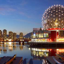

Epoch 0/3000 => Mean Loss of training at current step:: 7.213


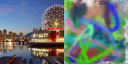

--------------------------------------------------
Epoch 100/3000 => Mean Loss of training at current step:: 4.813


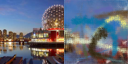

--------------------------------------------------
Epoch 200/3000 => Mean Loss of training at current step:: 4.355


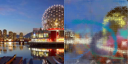

--------------------------------------------------
Epoch 300/3000 => Mean Loss of training at current step:: 4.086


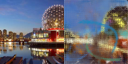

--------------------------------------------------
Epoch 400/3000 => Mean Loss of training at current step:: 3.913


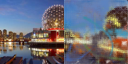

--------------------------------------------------
Epoch 500/3000 => Mean Loss of training at current step:: 3.791


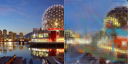

--------------------------------------------------
Epoch 600/3000 => Mean Loss of training at current step:: 3.695


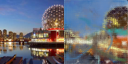

--------------------------------------------------
Epoch 700/3000 => Mean Loss of training at current step:: 3.623


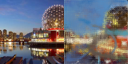

--------------------------------------------------
Epoch 800/3000 => Mean Loss of training at current step:: 3.563


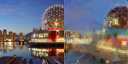

--------------------------------------------------
Epoch 900/3000 => Mean Loss of training at current step:: 3.509


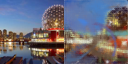

--------------------------------------------------
Epoch 1000/3000 => Mean Loss of training at current step:: 3.469


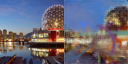

--------------------------------------------------
Epoch 1100/3000 => Mean Loss of training at current step:: 3.427


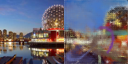

--------------------------------------------------
Epoch 1200/3000 => Mean Loss of training at current step:: 3.393


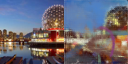

--------------------------------------------------
Epoch 1300/3000 => Mean Loss of training at current step:: 3.363


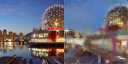

--------------------------------------------------
Epoch 1400/3000 => Mean Loss of training at current step:: 3.337


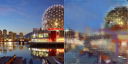

--------------------------------------------------
Epoch 1500/3000 => Mean Loss of training at current step:: 3.309


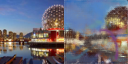

--------------------------------------------------
Epoch 1600/3000 => Mean Loss of training at current step:: 3.288


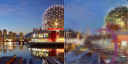

--------------------------------------------------
Epoch 1700/3000 => Mean Loss of training at current step:: 3.265


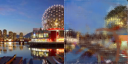

--------------------------------------------------
Epoch 1800/3000 => Mean Loss of training at current step:: 3.241


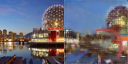

--------------------------------------------------
Epoch 1900/3000 => Mean Loss of training at current step:: 3.217


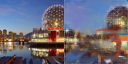

--------------------------------------------------
Epoch 2000/3000 => Mean Loss of training at current step:: 3.194


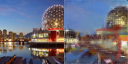

--------------------------------------------------
Epoch 2100/3000 => Mean Loss of training at current step:: 3.172


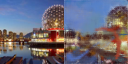

--------------------------------------------------
Epoch 2200/3000 => Mean Loss of training at current step:: 3.154


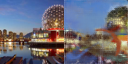

--------------------------------------------------
Epoch 2300/3000 => Mean Loss of training at current step:: 3.138


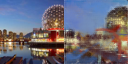

--------------------------------------------------
Epoch 2400/3000 => Mean Loss of training at current step:: 3.121


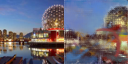

--------------------------------------------------
Epoch 2500/3000 => Mean Loss of training at current step:: 3.106


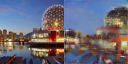

--------------------------------------------------
Epoch 2600/3000 => Mean Loss of training at current step:: 3.092


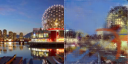

--------------------------------------------------
Epoch 2700/3000 => Mean Loss of training at current step:: 3.083


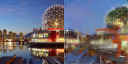

--------------------------------------------------
Epoch 2800/3000 => Mean Loss of training at current step:: 3.069


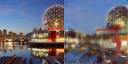

--------------------------------------------------
Epoch 2900/3000 => Mean Loss of training at current step:: 3.058


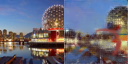

--------------------------------------------------
End of training => Mean Loss of training: 3.047


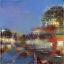


Image is saved to /content/gdrive/MyDrive/NaturalPainters/images/painted_images/vanc/painted_vanc_2022-02-17 03:05:00_3000e_4seed.png.

Image to paint is an image of louvre:


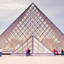

Epoch 0/3000 => Mean Loss of training at current step:: 7.490


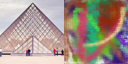

--------------------------------------------------
Epoch 100/3000 => Mean Loss of training at current step:: 4.444


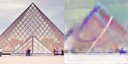

--------------------------------------------------
Epoch 200/3000 => Mean Loss of training at current step:: 3.792


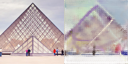

--------------------------------------------------
Epoch 300/3000 => Mean Loss of training at current step:: 3.481


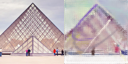

--------------------------------------------------
Epoch 400/3000 => Mean Loss of training at current step:: 3.286


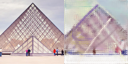

--------------------------------------------------
Epoch 500/3000 => Mean Loss of training at current step:: 3.158


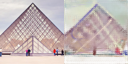

--------------------------------------------------
Epoch 600/3000 => Mean Loss of training at current step:: 3.048


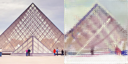

--------------------------------------------------
Epoch 700/3000 => Mean Loss of training at current step:: 2.966


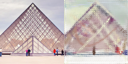

--------------------------------------------------
Epoch 800/3000 => Mean Loss of training at current step:: 2.909


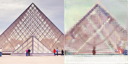

--------------------------------------------------
Epoch 900/3000 => Mean Loss of training at current step:: 2.864


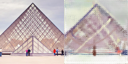

--------------------------------------------------
Epoch 1000/3000 => Mean Loss of training at current step:: 2.821


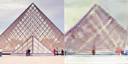

--------------------------------------------------
Epoch 1100/3000 => Mean Loss of training at current step:: 2.783


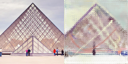

--------------------------------------------------
Epoch 1200/3000 => Mean Loss of training at current step:: 2.756


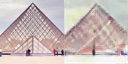

--------------------------------------------------
Epoch 1300/3000 => Mean Loss of training at current step:: 2.727


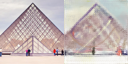

--------------------------------------------------
Epoch 1400/3000 => Mean Loss of training at current step:: 2.700


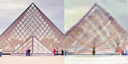

--------------------------------------------------
Epoch 1500/3000 => Mean Loss of training at current step:: 2.677


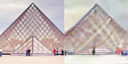

--------------------------------------------------
Epoch 1600/3000 => Mean Loss of training at current step:: 2.655


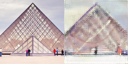

--------------------------------------------------
Epoch 1700/3000 => Mean Loss of training at current step:: 2.634


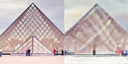

--------------------------------------------------
Epoch 1800/3000 => Mean Loss of training at current step:: 2.617


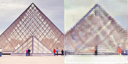

--------------------------------------------------
Epoch 1900/3000 => Mean Loss of training at current step:: 2.603


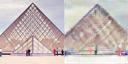

--------------------------------------------------
Epoch 2000/3000 => Mean Loss of training at current step:: 2.587


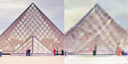

--------------------------------------------------
Epoch 2100/3000 => Mean Loss of training at current step:: 2.575


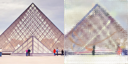

--------------------------------------------------
Epoch 2200/3000 => Mean Loss of training at current step:: 2.565


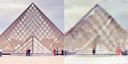

--------------------------------------------------
Epoch 2300/3000 => Mean Loss of training at current step:: 2.552


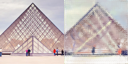

--------------------------------------------------
Epoch 2400/3000 => Mean Loss of training at current step:: 2.543


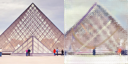

--------------------------------------------------
Epoch 2500/3000 => Mean Loss of training at current step:: 2.534


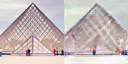

--------------------------------------------------
Epoch 2600/3000 => Mean Loss of training at current step:: 2.523


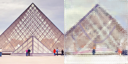

--------------------------------------------------
Epoch 2700/3000 => Mean Loss of training at current step:: 2.514


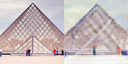

--------------------------------------------------
Epoch 2800/3000 => Mean Loss of training at current step:: 2.506


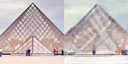

--------------------------------------------------
Epoch 2900/3000 => Mean Loss of training at current step:: 2.498


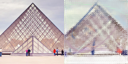

--------------------------------------------------
End of training => Mean Loss of training: 2.491


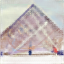


Image is saved to /content/gdrive/MyDrive/NaturalPainters/images/painted_images/louvre/painted_louvre_2022-02-17 03:13:00_3000e_4seed.png.

Image to paint is an image of eiffel:


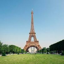

Epoch 0/3000 => Mean Loss of training at current step:: 9.236


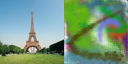

--------------------------------------------------
Epoch 100/3000 => Mean Loss of training at current step:: 4.614


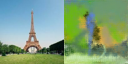

--------------------------------------------------
Epoch 200/3000 => Mean Loss of training at current step:: 4.102


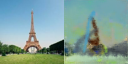

--------------------------------------------------
Epoch 300/3000 => Mean Loss of training at current step:: 3.709


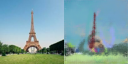

--------------------------------------------------
Epoch 400/3000 => Mean Loss of training at current step:: 3.416


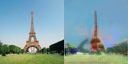

--------------------------------------------------
Epoch 500/3000 => Mean Loss of training at current step:: 3.193


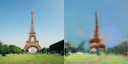

--------------------------------------------------
Epoch 600/3000 => Mean Loss of training at current step:: 3.036


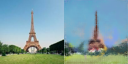

--------------------------------------------------
Epoch 700/3000 => Mean Loss of training at current step:: 2.913


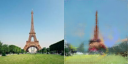

--------------------------------------------------
Epoch 800/3000 => Mean Loss of training at current step:: 2.817


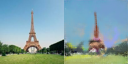

--------------------------------------------------
Epoch 900/3000 => Mean Loss of training at current step:: 2.743


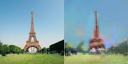

--------------------------------------------------
Epoch 1000/3000 => Mean Loss of training at current step:: 2.678


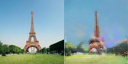

--------------------------------------------------
Epoch 1100/3000 => Mean Loss of training at current step:: 2.621


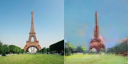

--------------------------------------------------
Epoch 1200/3000 => Mean Loss of training at current step:: 2.567


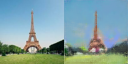

--------------------------------------------------
Epoch 1300/3000 => Mean Loss of training at current step:: 2.523


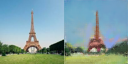

--------------------------------------------------
Epoch 1400/3000 => Mean Loss of training at current step:: 2.483


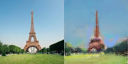

--------------------------------------------------
Epoch 1500/3000 => Mean Loss of training at current step:: 2.442


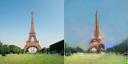

--------------------------------------------------
Epoch 1600/3000 => Mean Loss of training at current step:: 2.407


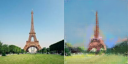

--------------------------------------------------
Epoch 1700/3000 => Mean Loss of training at current step:: 2.377


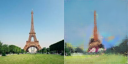

--------------------------------------------------
Epoch 1800/3000 => Mean Loss of training at current step:: 2.354


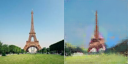

--------------------------------------------------
Epoch 1900/3000 => Mean Loss of training at current step:: 2.330


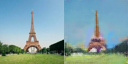

--------------------------------------------------
Epoch 2000/3000 => Mean Loss of training at current step:: 2.310


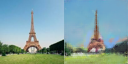

--------------------------------------------------
Epoch 2100/3000 => Mean Loss of training at current step:: 2.288


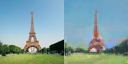

--------------------------------------------------
Epoch 2200/3000 => Mean Loss of training at current step:: 2.270


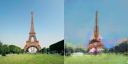

--------------------------------------------------
Epoch 2300/3000 => Mean Loss of training at current step:: 2.253


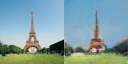

--------------------------------------------------
Epoch 2400/3000 => Mean Loss of training at current step:: 2.238


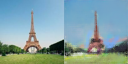

--------------------------------------------------
Epoch 2500/3000 => Mean Loss of training at current step:: 2.224


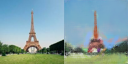

--------------------------------------------------
Epoch 2600/3000 => Mean Loss of training at current step:: 2.210


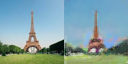

--------------------------------------------------
Epoch 2700/3000 => Mean Loss of training at current step:: 2.197


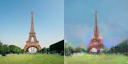

--------------------------------------------------
Epoch 2800/3000 => Mean Loss of training at current step:: 2.185


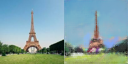

--------------------------------------------------
Epoch 2900/3000 => Mean Loss of training at current step:: 2.175


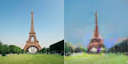

--------------------------------------------------
End of training => Mean Loss of training: 2.163


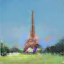


Image is saved to /content/gdrive/MyDrive/NaturalPainters/images/painted_images/eiffel/painted_eiffel_2022-02-17 03:20:00_3000e_4seed.png.

Image to paint is an image of castle:


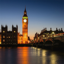

Epoch 0/3000 => Mean Loss of training at current step:: 7.789


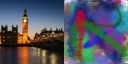

--------------------------------------------------
Epoch 100/3000 => Mean Loss of training at current step:: 4.711


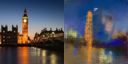

--------------------------------------------------
Epoch 200/3000 => Mean Loss of training at current step:: 4.197


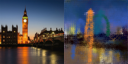

--------------------------------------------------
Epoch 300/3000 => Mean Loss of training at current step:: 3.885


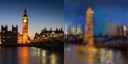

--------------------------------------------------
Epoch 400/3000 => Mean Loss of training at current step:: 3.675


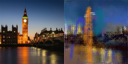

--------------------------------------------------
Epoch 500/3000 => Mean Loss of training at current step:: 3.525


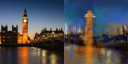

--------------------------------------------------
Epoch 600/3000 => Mean Loss of training at current step:: 3.416


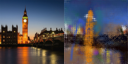

--------------------------------------------------
Epoch 700/3000 => Mean Loss of training at current step:: 3.335


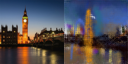

--------------------------------------------------
Epoch 800/3000 => Mean Loss of training at current step:: 3.273


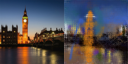

--------------------------------------------------
Epoch 900/3000 => Mean Loss of training at current step:: 3.221


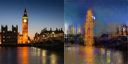

--------------------------------------------------
Epoch 1000/3000 => Mean Loss of training at current step:: 3.172


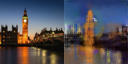

--------------------------------------------------
Epoch 1100/3000 => Mean Loss of training at current step:: 3.130


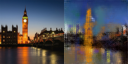

--------------------------------------------------
Epoch 1200/3000 => Mean Loss of training at current step:: 3.096


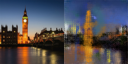

--------------------------------------------------
Epoch 1300/3000 => Mean Loss of training at current step:: 3.063


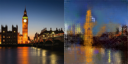

--------------------------------------------------
Epoch 1400/3000 => Mean Loss of training at current step:: 3.039


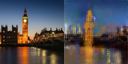

--------------------------------------------------
Epoch 1500/3000 => Mean Loss of training at current step:: 3.016


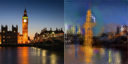

--------------------------------------------------
Epoch 1600/3000 => Mean Loss of training at current step:: 2.995


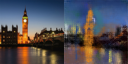

--------------------------------------------------
Epoch 1700/3000 => Mean Loss of training at current step:: 2.977


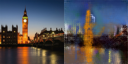

--------------------------------------------------
Epoch 1800/3000 => Mean Loss of training at current step:: 2.959


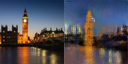

--------------------------------------------------
Epoch 1900/3000 => Mean Loss of training at current step:: 2.945


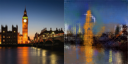

--------------------------------------------------
Epoch 2000/3000 => Mean Loss of training at current step:: 2.930


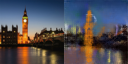

--------------------------------------------------
Epoch 2100/3000 => Mean Loss of training at current step:: 2.916


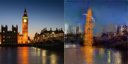

--------------------------------------------------
Epoch 2200/3000 => Mean Loss of training at current step:: 2.901


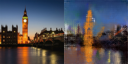

--------------------------------------------------
Epoch 2300/3000 => Mean Loss of training at current step:: 2.889


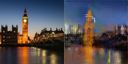

--------------------------------------------------
Epoch 2400/3000 => Mean Loss of training at current step:: 2.878


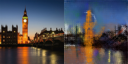

--------------------------------------------------
Epoch 2500/3000 => Mean Loss of training at current step:: 2.865


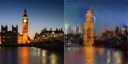

--------------------------------------------------
Epoch 2600/3000 => Mean Loss of training at current step:: 2.855


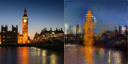

--------------------------------------------------
Epoch 2700/3000 => Mean Loss of training at current step:: 2.844


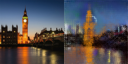

--------------------------------------------------
Epoch 2800/3000 => Mean Loss of training at current step:: 2.835


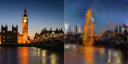

--------------------------------------------------
Epoch 2900/3000 => Mean Loss of training at current step:: 2.825


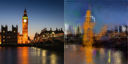

--------------------------------------------------
End of training => Mean Loss of training: 2.816


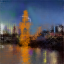


Image is saved to /content/gdrive/MyDrive/NaturalPainters/images/painted_images/castle/painted_castle_2022-02-17 03:28:00_3000e_4seed.png.


In [19]:
# set either repeated or random experiment
torch.manual_seed(SEED)

collection_of_histories = {} # dictionary of dictionaries
collection_of_canvas_evolutions = [] # list of lists: final canvas painted stroke by stroke for each source image
collection_of_train_evolutions = [] # lits of lists: development of final canvases with training stage for each source image

# iterate over images of interest
for img_path in image_path_list:

    # get image content
    img_to_paint_name, img_to_paint, img_to_paint_tensor = generate_source_to_paint(img_path)

    # initialize actions randomly with U[0,1]
    # shape is (desired_number_of_strokes, 12) 
    actions = torch.empty((hparams.in_strokes, hparams.in_features), device = device).uniform_().requires_grad_(True)

    # create an instance of optimizer
    optimizer = optim.RMSprop([actions], lr = hparams.lr)  

    # create model instance of Painter
    trainer = Trainer(generator,
                      feature_extractor,
                      optimizer,
                      img_to_paint_tensor = img_to_paint_tensor,
                      epochs = hparams.epochs,
                      gpu = gpu) 
     
    # generate paths for saving
    loss_path = generate_path(hparams.epochs, mode = 'loss')
    paint_path = generate_path(hparams.epochs, img_to_paint_name = img_to_paint_name, inter_folder = '/painted_')
    final_path = generate_path(hparams.epochs, img_to_paint_name = img_to_paint_name, inter_folder = '/frames/')
    train_path = generate_path(hparams.epochs, img_to_paint_name = img_to_paint_name, inter_folder = '/train_frames/')

    # call the training method with the desired saving paths
    train_history = trainer.train(actions, 
                                  save_img_path = paint_path + '.png',
                                  print_interval = hparams.print_interval)
    
    # element of dictionary - training history for i-th source image
    collection_of_histories[img_to_paint_name] = train_history
    # save frames of stroke-by-stroke painting of the final learnt canvas for the i-th source image 
    final_canvas_evolution = trainer.save_frames(save_frames_path = final_path + '_', only_final = True)
    # save frames of final canvas over training steps
    train_canvas_evolution = trainer.save_frames(save_frames_path = train_path + '_', only_final = False)
    # element of list - corresponding set of frames for i-th source image
    collection_of_canvas_evolutions.append(final_canvas_evolution)
    collection_of_train_evolutions.append(train_canvas_evolution)

## **Loss History**

In [20]:
# plot and save train loss
def plot_loss(save_loss_path = '', model_name = 'Model',
              xlim = [], ylim = [],
              epochs = 1000):

    fig, axs = plt.subplots()

    legend_list = []
    for (key, value) in collection_of_histories.items():
        plt.plot(value['mean_train_loss'], '-', color = (random.random(), random.random(), random.random()))
        legend_list.append(key)

    plt.title(f'{model_name} loss collected over {epochs} epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')

    if xlim != []:
        plt.xlim(xlim)
    if ylim != []:
        plt.ylim(ylim)

    plt.legend(legend_list, loc = 'upper right')

    if save_loss_path != '':
        fig.savefig(save_loss_path, bbox_inches = 'tight')

    plt.show()

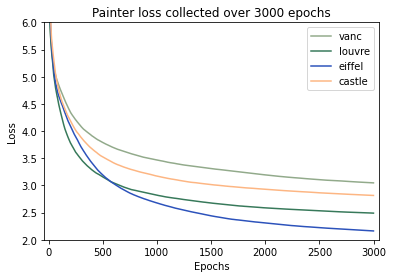

In [21]:
plot_loss(loss_path, 'Painter',
          xlim = [-40, 3050], ylim = [2, 6],
          epochs = hparams.epochs)

# **Making video**

Two **helpful utilities** involved in the process of creating mp4 videos of paintings.



In [91]:
# creates animation given collection of frames 
# used for both evolution of final canvas with training and evolution of final cnvas painting stroke-by-stroke
# when the function is called, there will be animation, after execution finishes - static final painting will be left printed out
def animate(img_to_paint_tensor, final_canvas_evolution):
    for cur_canvas in final_canvas_evolution:
        stacked_img = torch.cat((img_to_paint_tensor.clone().cpu(), to_tensor(cur_canvas)), dim = 2)
        display(to_pil_image(stacked_img))
        time.sleep(hparams.secs)
        clear_output(wait = True)

# removal timestamps from the names of files
def rename_frames(path_to_frames, img_to_paint_name):
    for old_name in glob.glob(path_to_frames):
        new_name = old_name.split(img_to_paint_name)
        new_name[-1] = img_to_paint_name + '_' + new_name[-1].split('_')[-1]
        new_name[0] += img_to_paint_name
        new_name = ''.join(new_name)
        os.rename(old_name, new_name)
        
train_videopaths = []
final_videopaths = []

## **Vancouver**

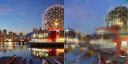

In [92]:
# animated vancouver painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[0])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/vanc/frames/last_timestamp/vanc_%03d.png'
video_path = './images/painted_images/vanc/vanc_final1.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[0])

In [74]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

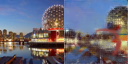

In [93]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/vanc/train_frames/last_timestamp/vanc_%03d.png'
video_path = './images/painted_images/vanc/vanc_train1.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[0])

In [76]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Louvre**

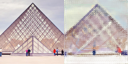

In [94]:
# animated louvre painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[1])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/louvre/frames/last_timestamp/louvre_%03d.png'
video_path = './images/painted_images/louvre/louvre_final1.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[1])

In [78]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

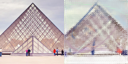

In [95]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/louvre/train_frames/last_timestamp/louvre_%03d.png'
video_path = './images/painted_images/louvre/louvre_train1.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[1])

In [80]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Eiffel**

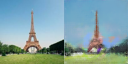

In [96]:
# animated eiffel painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[2])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/eiffel/frames/last_timestamp/eiffel_%03d.png'
video_path = './images/painted_images/eiffel/eiffel_final1.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[2])

In [82]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

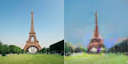

In [97]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/eiffel/train_frames/last_timestamp/eiffel_%03d.png'
video_path = './images/painted_images/eiffel/eiffel_train1.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[2])

In [84]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Castle**

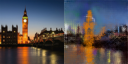

In [98]:
# animated castle painting
img_to_paint_name, _, img_to_paint_tensor = generate_source_to_paint(image_path_list[3])
#rename_frames(save_images_path + img_to_paint_name + '/frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/castle/frames/last_timestamp/castle_%03d.png'
video_path = './images/painted_images/castle/castle_final1.mp4'
final_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_canvas_evolutions[3])

In [86]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

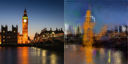

In [99]:
#rename_frames(save_images_path + img_to_paint_name + '/train_frames/last_timestamp/*', img_to_paint_name)
frames_path = './images/painted_images/castle/train_frames/last_timestamp/castle_%03d.png'
video_path = './images/painted_images/castle/castle_train1.mp4'
train_videopaths.append(video_path)
animate(img_to_paint_tensor, collection_of_train_evolutions[3])

In [88]:
!ffmpeg -loglevel panic -y -framerate 8 -i $frames_path -s:v 128x64 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p $video_path

## **Video gallery**

Evolution of the final canvas **with epochs** of training.

In [100]:
html_str=""
for filepath in set(train_videopaths):
  mp4 = open(filepath,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  html_str += """
  <video width=128 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
HTML(html_str)

Painting of the final learnt canvas **stroke-by-stroke**.

In [101]:
html_str=""
for filepath in set(final_videopaths):
  mp4 = open(filepath,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  html_str += """
  <video width=128 controls>
        <source src="%s" type="video/mp4">
  </video>
  """ % data_url
HTML(html_str)